# Pyspark TensorFlow Training

Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

## Single Node Training on Driver

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2023-01-05 16:09:57.401409: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.1


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


2023-01-05 16:09:59.431796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1922] Ignoring visible gpu device (device: 1, name: Quadro P620, pci bus id: 0000:65:00.0, compute capability: 6.1) with core count: 4. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-01-05 16:09:59.432350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 16:09:59.794436: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-01-05 16:09:59.794476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created

### Train model

In [6]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
  44/1875 [..............................] - ETA: 6s - loss: 1.0386 - sparse_categorical_accuracy: 0.6918 

2023-01-05 16:10:01.020358: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.2174 - sparse_categorical_accuracy: 0.9362 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9691
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.0867 - val_sparse_categorical_accuracy: 0.9725
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0712 - val_sparse_categorical_accuracy: 0.9782
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0635 - val_sparse_categorical_accuracy: 0.9801
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9863 - val_loss: 0.0620 - val_sparse_categorical_accuracy: 0.9820


In [7]:
test_img = test_images[:1]
model.predict(test_img)

1/1 [==============================] - 0s 54ms/step


array([[ -5.797349 ,  -7.324735 ,  -4.530537 ,  -1.59399  , -14.33293  ,
         -8.626202 , -16.838335 ,  12.26039  ,  -6.1140094,  -1.9424609]],
      dtype=float32)

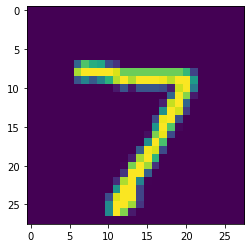

In [8]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [9]:
subprocess.call("rm -rf mnist_model".split())

0

In [10]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


## Distributed Training on executors

### Save dataset as parquet

In [11]:
import pandas as pd
pdf_784 = pd.DataFrame(train_images)
pdf_labels = pd.DataFrame(train_labels)

In [12]:
pdf_train = pd.DataFrame()

In [13]:
pdf_train['image'] = pdf_784.values.tolist()
pdf_train['label'] = pdf_labels

In [14]:
pdf_train

,image,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
...,...,...
59995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8
59996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
59997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
59998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6


In [15]:
df_train = spark.createDataFrame(pdf_train)

In [16]:
df_train.write.mode("overwrite").parquet("mnist_train")

23/01/05 16:12:04 WARN TaskSetManager: Stage 0 contains a task of very large size (21199 KiB). The maximum recommended task size is 1000 KiB.


### mapInPandas

In [17]:
df_train = spark.read.parquet("mnist_train")

In [18]:
def train(df_iter):
    import json
    import os
    import random
    import socket
    import tensorflow as tf
    import time
    import numpy as np
    from pyspark import BarrierTaskContext
    from datetime import datetime
    
    print("{}: {}: GOT HERE 1".format(datetime.now(), os.getpid()))
    # get list of participating nodes and my local address
    context = BarrierTaskContext.get()
    task_infos = context.getTaskInfos()
    workers = [t.address.split(':')[0] for t in task_infos]
    rank = context.partitionId()
    addr = workers[rank]

    # find available port for TF server 
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        sock.bind(('', 0))
        _, port = sock.getsockname()
        tf_addr = "{}:{}".format(addr, port)
        tf_addresses = context.allGather(tf_addr)
    
    # configure TF_CONFIG
    TF_CONFIG = {
        "cluster": {"worker": tf_addresses}, 
        "task": {"type": "worker", "index": rank}
    }
    print(f"TF_CONFIG = {TF_CONFIG}")
    os.environ['TF_CONFIG'] = json.dumps(TF_CONFIG)
    
    # run the training code
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope():

        # Define a simple sequential model
        def create_model():
            model = tf.keras.models.Sequential([
                keras.layers.Dense(512, activation='relu', input_shape=(784,)),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(10)
            ])

            model.compile(optimizer='adam',
                            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=[tf.metrics.SparseCategoricalAccuracy()])

            return model

        # Create a basic model instance
        model = create_model()

        # Display the model's architecture
        model.summary()

        # simulate random startup latency
        time.sleep(random.randint(0,5))

        print("{}: {}: waiting for barrier".format(datetime.now(), os.getpid()))
        context.barrier()
        print("{}: {}: continuing".format(datetime.now(), os.getpid()))

        for pdf in df_iter:
            print(type(pdf), len(pdf))
            x = np.vstack(pdf['image'].to_numpy())
            y = pdf['label'].to_numpy()
            model.fit(x, y)
            yield pdf
            
        # TODO: after last iter, checkpoint model

In [19]:
rdd_out = df_train \
    .repartition(2) \
    .mapInPandas(train, schema="image array<float>, label float") \
    .rdd \
    .barrier() \
    .mapPartitions(lambda x: x) \
    .collect()

## Refactored

In [26]:
df_train = spark.read.parquet("mnist_train")

In [27]:
from abc import ABC
from pyspark import BarrierTaskContext

class FrameworkPlugin(ABC):
    @staticmethod    
    def setup(context: BarrierTaskContext):
        pass
    
    @staticmethod
    def teardown(self):
        pass

In [28]:
class TensorFlowPlugin(FrameworkPlugin):
    @staticmethod
    def setup(context: BarrierTaskContext):
        import json
        import socket

        task_infos = context.getTaskInfos()
        workers = [t.address.split(':')[0] for t in task_infos]
        rank = context.partitionId()
        world_size = len(workers)
        my_addr = workers[rank]

        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
            # find available port for TF server 
            sock.bind(('', 0))
            _, port = sock.getsockname()
            tf_addr = "{}:{}".format(my_addr, port)
            tf_addresses = context.allGather(tf_addr)

            # configure TF_CONFIG
            TF_CONFIG = {
                "cluster": {"worker": tf_addresses}, 
                "task": {"type": "worker", "index": rank}
            }
            print(f"TF_CONFIG = {TF_CONFIG}")
            os.environ['TF_CONFIG'] = json.dumps(TF_CONFIG)

            return rank, world_size
    
    @staticmethod
    def teardown():
        pass

In [29]:
import functools

def distribute(framework_plugin):
    def decorator_distribute(train_fn):
        @functools.wraps(train_fn)
        def _wrapper(df_iter):
            from pyspark import BarrierTaskContext

            # get list of participating nodes and my local address
            context = BarrierTaskContext.get()         
            rank, world_size = framework_plugin.setup(context)      
            result = train_fn(df_iter)
            framework_plugin.teardown()
            return result
        return _wrapper
    return decorator_distribute

In [30]:
@distribute(TensorFlowPlugin)
def train_fn(df_iter):
    import numpy as np
    import tensorflow as tf
    
    # run the training code
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope():

        # Define a simple sequential model
        def create_model():
            model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(512, activation='relu', input_shape=(784,)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(10)
            ])

            model.compile(optimizer='adam',
                            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=[tf.metrics.SparseCategoricalAccuracy()])

            return model

        # Create a basic model instance
        model = create_model()

        # Display the model's architecture
        model.summary()

        # Receive data from Spark
        for pdf in df_iter:
            print(type(pdf), len(pdf))
            x = np.vstack(pdf['image'].to_numpy())
            y = pdf['label'].to_numpy()
            model.fit(x, y)
            yield pdf

In [31]:
rdd_out = df_train \
    .repartition(2) \
    .mapInPandas(train_fn, schema="image array<float>, label float") \
    .rdd \
    .barrier() \
    .mapPartitions(lambda x: x) \
    .collect()